In [1]:
import time
import numpy as np
import qiskit.tools.jupyter
from qiskit import *
from matplotlib import pyplot as plt
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.tools.monitor import job_monitor
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics

%matplotlib inline
%qiskit_version_table

plt.style.use('dark_background')

Qiskit Software,Version
qiskit-terra,0.18.0
qiskit-aer,0.8.2
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.13.1
qiskit-aqua,0.9.1
qiskit,0.27.0
qiskit-nature,0.1.4
qiskit-finance,0.2.0
qiskit-optimization,0.2.0
qiskit-machine-learning,0.2.0


In [2]:
# set up
feature_dim = 2
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 12345
algorithm_globals.random_seed = random_seed
shots = 1024

# helper functions
def plot_func(input_type, input_labels, i, marker, facecolors, edgecolors, label):
    plt.scatter(input_type[np.where(input_labels[:]==i), 0], 
                input_type[np.where(input_labels[:]==i), 1], 
                marker=marker, facecolors=facecolors, edgecolors=edgecolors, label=label)

def display_func(matrix_type, interpolation, origin, cmap, extent):
    return plt.imshow(np.asmatrix(matrix_type).T, interpolation=interpolation, 
               origin=origin, cmap=cmap, extent=extent)

def colorbar_display():
    ax = plt.subplot()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(im, cax=cax)
    
def plot_data(input_type, input_labels, facecolor1, facecolor2, edgecolor1, edgecolor2, label1, label2):
    plot_func(input_type, input_labels, 0, 's', facecolor1, edgecolor1, label1)
    plot_func(input_type, input_labels, 1, 'o', facecolor2, edgecolor2, label2)
    

# input ad hoc data
train_input, train_labels, test_input, test_labels, sample_total = ad_hoc_data(training_size=training_dataset_size, 
                                                                               test_size=testing_dataset_size, 
                                                                               n=feature_dim, gap=0.3, plot_data=False, 
                                                                               one_hot=False, include_sample_total=True)

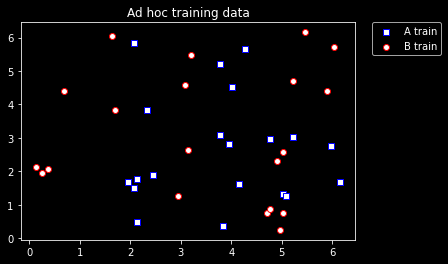

In [3]:
# plot training data
plot_data(train_input, train_labels, 'w', 'w', 'b', 'r', 'A train', 'B train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Ad hoc training data")
plt.show()

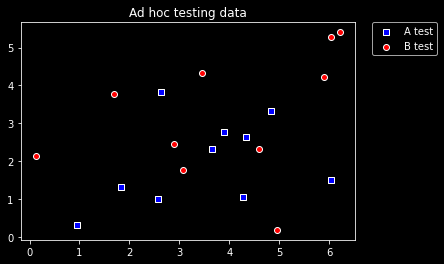

In [4]:
# plot testing data
plot_data(test_input, test_labels, 'b', 'r', 'w', 'w', 'A test', 'B test')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Ad hoc testing data')
plt.show()

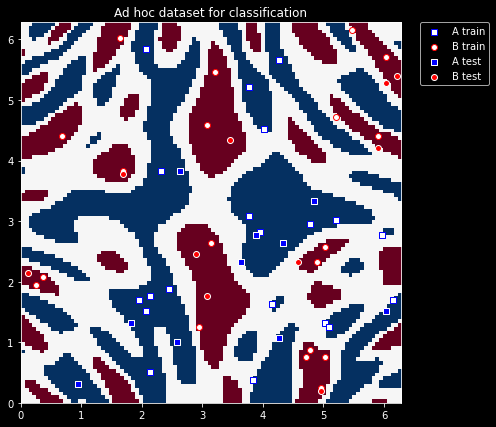

In [5]:
# plot dataset classification
plt.figure(figsize=(7, 7))
plt.ylim(0, 2*np.pi)
plt.xlim(0, 2*np.pi)
im = display_func(sample_total, 'nearest', 'lower', 'RdBu', [0, 2*np.pi, 0, 2*np.pi])
plot_data(train_input, train_labels, 'w', 'w', 'b', 'r', 'A train', 'B train')
plot_data(test_input, test_labels, 'b', 'r', 'w', 'w', 'A test', 'B test')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Ad hoc dataset for classification')
plt.show()

In [6]:
# set up classical SVM 
start_time = time.time()
clf = svm.SVC(kernel='linear')
clf.fit(train_input, train_labels)
result = clf.score(test_input, test_labels)
prediction_labels = clf.predict(test_input)
# print out execution time
print("execution time: %s seconds" % (time.time() - start_time))

execution time: 0.0020029544830322266 seconds


In [7]:
# ground truth and prediction comparison
print('ground truth: {}'.format(test_labels))
print('prediction:   {}'.format(prediction_labels))

ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:   [1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1]


In [8]:
# total accuracy
print("Accuracy:", metrics.accuracy_score(test_labels, prediction_labels))
# positive tuples accuracy
print("Precision:", metrics.precision_score(test_labels, prediction_labels))
# negative tuples accuracy
print("Recall:", metrics.recall_score(test_labels, prediction_labels))

Accuracy: 0.75
Precision: 0.8571428571428571
Recall: 0.6


In [9]:
# set up qsvm
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=shots, 
                                   seed_simulator=random_seed, 
                                   seed_transpiler=random_seed)
feature_map = ZZFeatureMap(feature_dimension=feature_dim, 
                           reps=2, entanglement='linear')

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(train_input, train_labels)
result = qsvc.score(test_input, test_labels)

In [10]:
# set up kernel matrices
kernel_train = kernel.evaluate(x_vec=train_input)
kernel_test = kernel.evaluate(x_vec=test_input, y_vec=train_input)

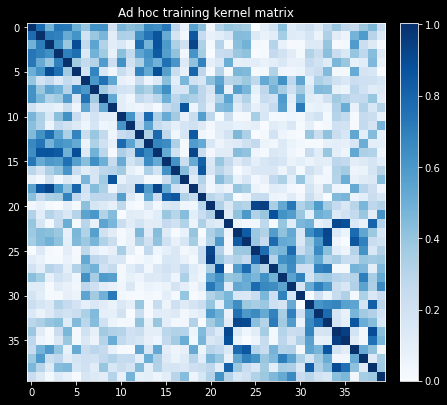

In [11]:
# plot kernel training matrix
plt.figure(figsize=(7, 7))
im = display_func(kernel_train, 'nearest', 'upper', 'Blues', None)
plt.title('Ad hoc training kernel matrix')
colorbar_display()
plt.show()

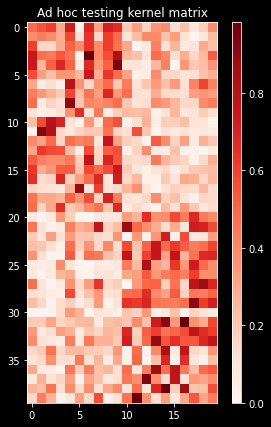

In [12]:
# plot kernel testing matrix
plt.figure(figsize=(7, 7))
im = display_func(kernel_test, 'nearest', 'upper', 'Reds', None)
plt.title('Ad hoc testing kernel matrix')
colorbar_display()
plt.show()

In [13]:
# ground truth and prediction comparison
predicted_labels = qsvc.predict(test_input)
print('ground truth: {}'.format(test_labels))
print('prediction:   {}'.format(predicted_labels))
print('testing success ratio: ', result)

ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:   [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
testing success ratio:  1.0


In [14]:
# connect to IBMQ 
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')

In [15]:
# set up job for IBMQ
quantum_ins = QuantumInstance(device, shots=shots,
                             seed_simulator=random_seed,
                             seed_transpiler=random_seed)
quantum_ker = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
qsvm = QSVC(quantum_kernel=quantum_ker)
qsvm.fit(train_input, train_labels)
result = qsvm.score(test_input, test_labels)

In [16]:
# print out execution time for IBMQ's job
jobs = device.jobs()
print(jobs[0].job_id())
job_monitor(jobs[0])
print("execution time: %s seconds" % jobs[0].result().time_taken)

60de82b51e35828e7af01b2b
Job Status: job has successfully run
execution time: 3.127653121948242 seconds


In [17]:
# ground truth and prediction comparison on IBMQ
predicted_labels = qsvc.predict(test_input)
print('ground truth: {}'.format(test_labels))
print('prediction:   {}'.format(predicted_labels))
print('testing success ratio: ', result)

ground truth: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
prediction:   [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
testing success ratio:  1.0
